In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
import torch.optim as optim

#from pytorch_lightning import seed_everything

from sklearn.model_selection import KFold, RepeatedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import scale

from tqdm import tqdm, trange
from math import floor

from lifelines.utils import concordance_index
from torchmtlr import (MTLR, mtlr_neg_log_likelihood, 
                       mtlr_risk, mtlr_survival, mtlr_survival_at_times)
from torchmtlr.utils import (make_time_bins, encode_survival, reset_parameters)

from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
import random

In [2]:
def make_data():
    """Load and preprocess the data."""
    try:
        X = pd.read_csv('hecktor2021_patient_info_training.csv')
        y = pd.read_csv('hecktor2021_patient_endpoint_training.csv')
        df = pd.merge(X, y, on="PatientID")
    except:
        df = path

    clinical_data = df

    clinical_data = clinical_data.rename(columns={"Progression": "event", "Progression free survival": "time", "TNM group":"Stage_group", "Gender (1=M,0=F)":"Gender"})
    # Convert time to months

    clinical_data["Age"] = scale(clinical_data["Age"])

    # binarize T stage as T1/2, T3/4
    clinical_data["T-stage"] = clinical_data["T-stage"].map(
        lambda x: "T1/2" if x in ["T1", "T2"] else("Tx" if x == "Tx" else "T3/4"), na_action="ignore")

    # use more fine-grained grouping for N stage
    clinical_data["N-stage"] = clinical_data["N-stage"].str.slice(0, 2)

    clinical_data["Stage_group"] = clinical_data["Stage_group"].map(
        lambda x: "I/II" if x in ["I", "II"] else "III/IV", na_action="ignore")

    clinical_data = pd.get_dummies(clinical_data,
                                   columns=["Gender",
                                            "N-stage",
                                            "M-stage", "T-stage", "Stage_group"])

    cols_to_drop = [
        "PatientID",
        "Tobacco",
        "Alcohol",
        "Performance status",
        "HPV status (0=-, 1=+)",
        "Estimated weight (kg) for SUV",

    ]


    clinical_data = clinical_data.drop(cols_to_drop, axis=1)

    return clinical_data

# Bayesian

In [3]:
df  = make_data()
print("The shape of the clinical dataframe is: " + str(df.shape))
df.head()

The shape of the clinical dataframe is: (222, 18)


,CenterID,Age,TNM edition,Chemotherapy,event,time,Gender_0,Gender_1,N-stage_N0,N-stage_N1,N-stage_N2,N-stage_N3,M-stage_M0,M-stage_M1,T-stage_T1/2,T-stage_T3/4,Stage_group_I/II,Stage_group_III/IV
0,1,-0.082540,7,1,1,310,0,1,0,0,1,0,1,0,0,1,0,1
1,1,-0.187851,7,1,0,2037,0,1,0,0,1,0,1,0,1,0,0,1
2,1,1.707732,7,1,0,1917,1,0,0,0,1,0,1,0,1,0,0,1
3,1,-0.082540,7,1,0,1377,1,0,0,0,1,0,1,0,0,1,0,1
4,1,-0.714401,7,1,0,1072,1,0,0,0,1,0,1,0,1,0,0,1


In [4]:
new_order = [4,5] + [i for i in np.arange(0,18) if i!=4 and i!=5]
df = df[df.columns[new_order]]

In [5]:
df.head()

,event,time,CenterID,Age,TNM edition,Chemotherapy,Gender_0,Gender_1,N-stage_N0,N-stage_N1,N-stage_N2,N-stage_N3,M-stage_M0,M-stage_M1,T-stage_T1/2,T-stage_T3/4,Stage_group_I/II,Stage_group_III/IV
0,1,310,1,-0.082540,7,1,0,1,0,0,1,0,1,0,0,1,0,1
1,0,2037,1,-0.187851,7,1,0,1,0,0,1,0,1,0,1,0,0,1
2,0,1917,1,1.707732,7,1,1,0,0,0,1,0,1,0,1,0,0,1
3,0,1377,1,-0.082540,7,1,1,0,0,0,1,0,1,0,0,1,0,1
4,0,1072,1,-0.714401,7,1,1,0,0,0,1,0,1,0,1,0,0,1


In [6]:
df = df.sort_values('time', ascending = False)

In [7]:
df.head()

,event,time,CenterID,Age,TNM edition,Chemotherapy,Gender_0,Gender_1,N-stage_N0,N-stage_N1,N-stage_N2,N-stage_N3,M-stage_M0,M-stage_M1,T-stage_T1/2,T-stage_T3/4,Stage_group_I/II,Stage_group_III/IV
21,0,3067,1,-1.556883,7,1,0,1,0,0,1,0,1,0,1,0,0,1
14,0,2927,1,-1.451572,7,1,1,0,0,0,1,0,1,0,1,0,0,1
23,0,2719,1,-1.030332,7,1,0,1,0,0,1,0,1,0,0,1,0,1
27,0,2715,1,0.128080,7,1,0,1,0,0,0,1,1,0,0,1,0,1
29,0,2653,1,-0.082540,7,1,0,1,0,0,1,0,1,0,1,0,0,1


In [8]:
time_bins = make_time_bins(df["time"], num_bins = 14, event=df["event"], use_quantiles=False)

y = encode_survival(df["time"].values, df["event"].values, time_bins)

X = torch.tensor(df.drop(["time", "event"], axis=1).values, dtype=torch.float)

num_features = df.shape[1] - 2
num_time_bins = len(time_bins)
X.shape

torch.Size([222, 16])

In [9]:
indices = np.arange(df.shape[0])
train_idx, val_idx = train_test_split(indices, test_size=0.1, random_state=42)

X_train, X_val, y_train =  X[train_idx], X[val_idx], y[train_idx]

y_val = df.iloc[val_idx]
y_val = (y_val[['time','event']].values) 

#### [Blitz - Bayesian Layers in Torch Zoo](https://github.com/piEsposito/blitz-bayesian-deep-learning)

BLiTZ is a simple and extensible library to create Bayesian Neural Network Layers (based on whats proposed in Weight Uncertainty in Neural Networks paper) on PyTorch. By using BLiTZ layers and utils, you can add uncertanity and gather the complexity cost of your model in a simple way that does not affect the interaction between your layers, as if you were using standard PyTorch.

In [13]:
@variational_estimator
class BayesianMTLR(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.mtlr2 = nn.Sequential(
            BayesianLinear(input_dim,64, prior_sigma_1 = 1, prior_sigma_2 = 0.002, prior_pi = 0.5),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0),
            MTLR(64, output_dim)

        )
        
    def forward(self, x):
        
        return self.mtlr2(x)

In [62]:
def evaluate_regression(surv_model,
                        X,
                        y,
                        samples = 100,
                        std_multiplier = 1.96,
                        eval_times=num_time_bins):

    preds_risk = []
    preds_survival = []

    for _ in range(samples):
        preds = surv_model(X)
        pred_r = mtlr_risk(preds).detach().numpy()
        preds_risk.append(pred_r)

        pred_s = mtlr_survival_at_times(preds, time_bins, eval_times)
        preds_survival.append(pred_s)


    
    preds_risk = np.stack(preds_risk)
    preds_survival = np.stack(preds_survival)

    preds_risk_mean = preds_risk.mean(axis=0)

    preds_survival_mean = preds_survival.mean(axis=0)
    stds_surv = np.sqrt((preds_survival_mean*(1 - preds_survival_mean))/samples)

    ci_event  = concordance_index(y[:,0], -preds_risk_mean, event_observed=y[:,1])


    survival_upper = preds_survival_mean + (std_multiplier * stds_surv)
    survival_lower = preds_survival_mean - (std_multiplier * stds_surv)

    return ci_event ,preds_survival_mean, survival_upper, survival_lower

In [63]:
class mtlr_neg_loss():

    def __init__(self, model, C1):

        self.model = model
        self.C1 = C1

    def __call__(self, outputs, labels):

        loss = mtlr_neg_log_likelihood(logits = outputs, target = labels, model = self.model, C1 = self.C1)
        return loss

In [64]:
regressor = BayesianMTLR(16, num_time_bins)
optimizer = optim.Adam(regressor.parameters(), lr=0.005)
criterion = mtlr_neg_loss(regressor, C1=100)

ds_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds_train, batch_size=16, shuffle=True)

C1 = 100

In [67]:
iteration = 0

df[df['event']==1]['time'].max()
eval_times = np.arange(0, df[df['event']==1]['time'].max()+1, 1)

for epoch in range(100):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()

        datapoints = datapoints
        labels = labels
        
        loss = regressor.sample_elbo(inputs=datapoints,
                           labels=labels,
                           criterion=criterion,
                           sample_nbr=5,
                           complexity_cost_weight=1/X_train.shape[0])
        loss.backward()
        optimizer.step()
        
        iteration += 1
        if iteration%100==0:
 
            ci, surv_mean_1000, survival_upper_1000, survival_lower_1000 = evaluate_regression(regressor,
                                                                        X_val,
                                                                        y_val,
                                                                        samples=1000,
                                                                        std_multiplier=1.96,
                                                                        eval_times=eval_times)
            
            print("CI acc: {:.2f}".format(ci))
            print("Loss: {:.4f}".format(loss))

CI acc: 0.57
Loss: 39.5096
CI acc: 0.55
Loss: 25.4680
CI acc: 0.52
Loss: 31.0063
CI acc: 0.62
Loss: 19.6084


/home/ryuzaki/anaconda3/envs/poppy/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


CI acc: 0.62
Loss: 29.2896
CI acc: 0.62
Loss: 29.1743
CI acc: 0.58
Loss: 23.5516
CI acc: 0.65
Loss: 21.9755
CI acc: 0.58
Loss: 23.2276
CI acc: 0.50
Loss: 30.6487
CI acc: 0.62
Loss: 29.0948
CI acc: 0.55
Loss: 18.7315
CI acc: 0.60
Loss: 20.4355


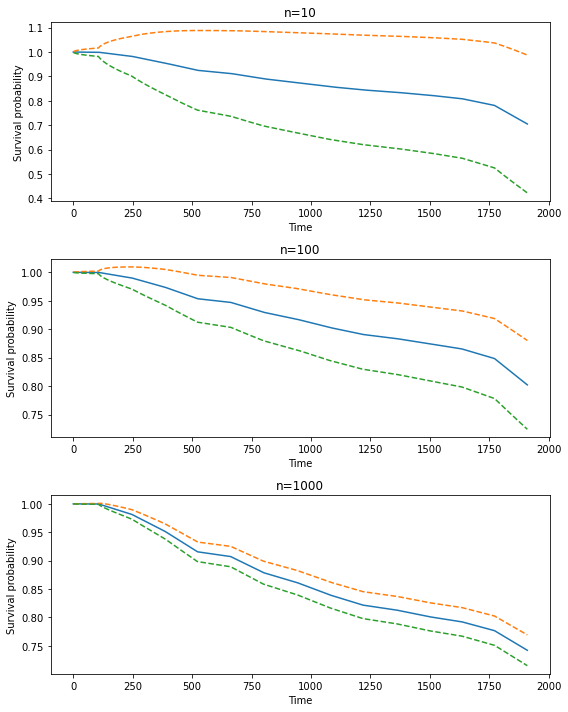

In [74]:
fig, axs = plt.subplots(3, figsize = (8,10))

axs[0].plot(surv_mean_10[20])
axs[0].plot(survival_upper_10[20], '--')
axs[0].plot(survival_lower_10[20], '--')
axs[0].set_title('n=10')
axs[0].set(xlabel='Time', ylabel='Survival probability')

axs[1].plot(surv_mean_100[20])
axs[1].plot(survival_upper_100[20], '--')
axs[1].plot(survival_lower_100[20], '--')
axs[1].set_title('n=100')
axs[1].set(xlabel='Time', ylabel='Survival probability')

axs[2].plot(surv_mean_1000[20])
axs[2].plot(survival_upper_1000[20], '--')
axs[2].plot(survival_lower_1000[20], '--')
axs[2].set_title('n=1000')
axs[2].set(xlabel='Time', ylabel='Survival probability')

plt.tight_layout()
plt.show()